# 卷积网络
## 感受野 receptive filed
卷积网络各输出特征图汇总每个像素点 在原始图片上映射回去的区域大小
对于一个5*5的图像来说 两个3 * 3的卷积核和一个5 * 5的卷积核最后都将特征变为1 * 1
按照感受野理论来说 他们的效果是一样的
但是两个3 * 3的参数量小于一个5 * 5的 所以多层的conv比较合适
## 填充 padding
使用填充padding 一般能够使得conv之后维度不变
当使用padding时 输出的维度是 padding = SAME 输入长度/步长(向上取整) 不使用padding时 输出的维度是 padding = VALID 输入长度-核长+1 / 步长 (向上取整)
## Conv2D
filters 卷积核个数
kernel_size 卷积核尺寸
strides 滑动步长
padding same / valid
activation # 如果有batch norm不写这个
input_shape
## batch norm
batch norm的作用是norm 拉回0均值1方差的标准分布
batch norm一般用在卷积之后 激活函数之前
在conv中维度本来是[batch, kernel, width, height] batch norm的效果是在batch * width * height维度上进行norm 就是在多个卷积核的每个卷积核上各自归一化

## 池化pool
**最大池化可以保留图片轮廓 均值池化可以保留背景特征**


In [ ]:
print('pooled output shape', result['pooled_output'].shape)
print('sequence output shape: ', result['sequence_output'].shape)

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import load_iris
import os
import pandas as pd
import numpy as np
import tensorflow.keras as keras
from keras import Model
from tensorflow.keras import Model
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # 使用 GPU 1
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0],True)
logical_devices = tf.config.list_logical_devices("GPU")

In [16]:
# dataset
cifar10 = keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [17]:
print('x_train_shape: ', x_train.shape)
print('y_train_shape: ', y_train.shape)
print('x_test_shape: ', x_test.shape)
print('y_test_shape: ', y_test.shape)

x_train_shape:  (50000, 32, 32, 3)
y_train_shape:  (50000, 1)
x_test_shape:  (10000, 32, 32, 3)
y_test_shape:  (10000, 1)


In [18]:
test_pic = x_train[6]
test_pic.shape

(32, 32, 3)

[2]


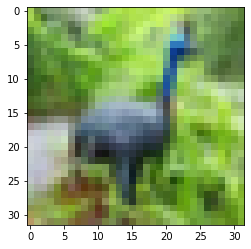

In [11]:
plt.imshow(test_pic)
print(y_train[6])

In [19]:
# 归一化
x_train = x_train / 255.0
x_test = x_test / 255.0

In [13]:
# model
class picModel(Model):
    def __init__(self, filters, kernel_size, padding, conv_stride, pool_size, pool_stride, hidden_size, dropout_rate):
        super(picModel, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.conv_stride = conv_stride
        self.pool_size = pool_size
        self.pool_stride = pool_stride
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate

        self.conv1 = keras.layers.Conv2D(filters = self.filters, kernel_size=self.kernel_size, strides=self.conv_stride,
                                         padding=self.padding, input_shape=(32,32,3), data_format='channels_last')
        self.bn = keras.layers.BatchNormalization()
        self.act = keras.layers.Activation('relu')
        self.maxpool = keras.layers.MaxPool2D(pool_size=self.pool_size, strides=self.pool_stride)
        self.flatten = keras.layers.Flatten()
        self.d1 = keras.layers.Dense(units=128, activation='relu')
        self.d2 = keras.layers.Dense(units=10, activation='softmax')
        self.dropout = keras.layers.Dropout(self.dropout_rate)

    def call(self, inputs, training=None, mask=None):
        x = self.conv1(inputs)
        x = self.bn(x)
        x = self.act(x)
        x = self.maxpool(x)
        x = self.dropout(x)

        x = self.flatten(x)
        x = self.d1(x)
        x = self.dropout(x)
        y = self.d2(x)
        return y

In [14]:
model = picModel(filters=6,kernel_size=(5,5), padding='same',conv_stride=1,pool_size=(2,2),pool_stride=2,hidden_size=128,dropout_rate=0.2)

In [20]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['sparse_categorical_accuracy']
)

In [22]:
checkpoint_save_path = 'tensorflow_study/chapter5/model_dir/simple_model/baseline.ckpt'

cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_save_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode = 'max',
)

In [23]:
history = model.fit(x_train, y_train,batch_size=64,epochs=200,validation_data=(x_test, y_test), validation_freq=5, callbacks=[cp_callback])

Epoch 1/200
782/782 [==============================] - 10s 4ms/step - loss: 1.6911 - sparse_categorical_accuracy: 0.3927
Epoch 2/200
782/782 [==============================] - 3s 4ms/step - loss: 1.4169 - sparse_categorical_accuracy: 0.4919
Epoch 3/200
782/782 [==============================] - 3s 4ms/step - loss: 1.3370 - sparse_categorical_accuracy: 0.5191
Epoch 4/200
782/782 [==============================] - 3s 4ms/step - loss: 1.2904 - sparse_categorical_accuracy: 0.5389
Epoch 5/200
782/782 [==============================] - 4s 6ms/step - loss: 1.2513 - sparse_categorical_accuracy: 0.5514 - val_loss: 1.2916 - val_sparse_categorical_accuracy: 0.5398
Epoch 6/200
782/782 [==============================] - 3s 4ms/step - loss: 1.2173 - sparse_categorical_accuracy: 0.5649
Epoch 7/200
782/782 [==============================] - 3s 4ms/step - loss: 1.1868 - sparse_categorical_accuracy: 0.5751
Epoch 8/200
782/782 [==============================] - 3s 4ms/step - loss: 1.1596 - sparse_categor

In [24]:
model.summary()

Model: "pic_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  456       
                                                                 
 batch_normalization (BatchN  multiple                 24        
 ormalization)                                                   
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  19

In [25]:
print(history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


In [26]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

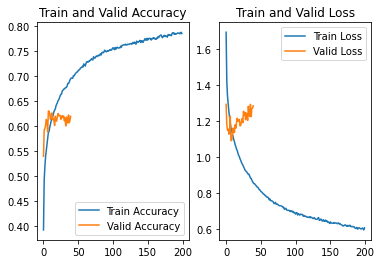

In [27]:
plt.subplot(1,2,1)
plt.plot(acc, label = 'Train Accuracy')
plt.plot(val_acc, label = 'Valid Accuracy')
plt.title('Train and Valid Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label = 'Train Loss')
plt.plot(val_loss, label = 'Valid Loss')
plt.title('Train and Valid Loss')
plt.legend()
plt.show()